In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from ray import tune #for hyper parameter tuning
import matplotlib.pyplot as plt
import scipy.stats as st
torch.manual_seed(0);

In [2]:
im_src= 'images\\NN\\maison2\\'

In [3]:
#load the data and show the first 3 data points
data = pd.read_csv('processed_data.csv')
data.head(3)

,Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Berri1,Maisonneuve_2,Maisonneuve_1
0,2009.0,1.0,1.0,-14.7,-19.9,-17.3,-23.125000,59.916667,28.291667,17.375000,29.0,35.0,20.0
1,2009.0,1.0,2.0,-11.3,-16.2,-13.8,-17.029167,76.250000,7.083333,12.250000,19.0,22.0,3.0
2,2009.0,1.0,3.0,-8.1,-13.0,-10.6,-15.441667,67.958333,28.208333,22.541667,24.0,22.0,12.0


In [4]:
#drop the y's from the X data and drop the dates on the X
X = torch.Tensor(data.drop(columns=['Berri1','Maisonneuve_2','Maisonneuve_1']).to_numpy())
X = X[:, 3:]
#select which of the 3 stations to train on
y = torch.Tensor(data['Maisonneuve_2'].to_numpy())

create custom bin sizes based on Freedman–Diaconis rule see: https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule

(16,)


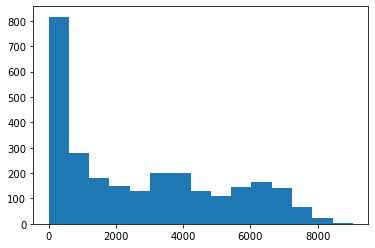

In [6]:
q3, q1 = np.percentile(y,[75,25])
bin_width = int(2*(q3-q1)/np.cbrt(len(y)))
bins = np.arange(0,max(y),bin_width)
print(bins.shape)
plt.hist(y.squeeze().numpy(), bins=bins)
plt.savefig(im_src+'\\bins',dpi=200)

In [7]:
bins.shape, bin_width

((16,), 603)

Create classes for each bin and one-hot encode the labels

In [8]:
y_bin = np.digitize(y.unsqueeze(1), bins)
from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder()
y_hot = torch.Tensor((one_hot.fit_transform(y_bin)).toarray())
y_hot[0:4]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
y_hot.shape

torch.Size([2743, 16])

Let's Split the test, train and validation datasets, we also scramble the data here

In [10]:
X_train,X_test, y_train, y_test = train_test_split(X,y_hot, test_size=0.10)

X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size=0.1)

print("X:", X.shape, "y:", y.shape,
      "\nX_train:", X_train.shape, "y_train:", y_train.shape,
      "\nX_test:", X_test.shape, "y_test:", y_test.shape,
     "\nX_val:", X_val.shape, "y_val:", y_val.shape)

X: torch.Size([2743, 7]) y: torch.Size([2743]) 
X_train: torch.Size([2468, 7]) y_train: torch.Size([2468, 16]) 
X_test: torch.Size([247, 7]) y_test: torch.Size([247, 16]) 
X_val: torch.Size([28, 7]) y_val: torch.Size([28, 16])


In [11]:
class BikeModel(torch.nn.Module):
    '''
    BikeModel neural network classifier
    __init__ : initializes the model specifying network shapes
    forward: incorporates the layers into the forward pass
    '''
    def __init__(self, linear=10, drop=0.50, out_features=16):
        super(BikeModel, self).__init__()
        self.linear1 = torch.nn.Linear(in_features=7, out_features=linear)
        self.linear2 = torch.nn.Linear(in_features=linear,out_features=linear)
        self.linear3 = torch.nn.Linear(in_features=linear,out_features=out_features)
        self.drop1 = torch.nn.Dropout(p=drop)
        self.drop2 = torch.nn.Dropout(p=drop)
    def forward(self, X):
        H = self.linear1(X)
        H = self.drop1(torch.nn.functional.relu(H))
        Z = self.linear2(H)
        Z = self.drop2(torch.nn.functional.relu(Z))
        Z = self.linear3(Z)
        return Z

In [12]:
#used to store loss results for plotting below
train_loss = []
test_loss = []

#Set to true to perform a hyperparameter search using RayTune
param_search=False
def train(config):
    '''
    Main ANN classifier function training the model in 1 of 2 modes: 
    
    -param_search=True
    -special training setting to use raytune for hyperparameter searching
    -config: leave empty as the "config" dictionnary will be supplied below, in the call to the RayTune run function
    note the data used should be changed to the "val" data from the "test" data
    
    -param_search=False,
    -typical training behaviour 
    -The hyperparameters are manually set below
    -prints losses 
    -returns the final model to calculate accuracies further below
    '''
    # Initialize the model 
    drop=0.5
    linear=60
    batch=1024
    epochs=700
    lr=0.005

    if config['param_search']:
        drop=config["drop"]
        linear=config["linear"]
        batch=config["batch"]
        epochs=config["epoch"]
        lr=config["lr"]

    ann = BikeModel(linear=linear, drop=drop, out_features=config['out_features'])
    batch_size= batch
    num_epoch = epochs

    # Initialize the Loss. 
    loss = torch.nn.CrossEntropyLoss()

    # Initialize the Optimizer.
    optimizer = torch.optim.AdamW(ann.parameters(), lr=lr)

    for epoch in range(num_epoch):
        ann.train() #set model to training mode
        for i in range(0, X_train.shape[0], batch_size):

            # Read minibatches (for both X and y)
            Xi = X_train[i:i+batch_size]
            yi = y_train[i:i+batch_size]

            # Run the RNN model
            output = ann.forward(Xi)

            l = loss(output,yi)

            # Update the parameters
            ann.zero_grad()
            l.backward()
            optimizer.step()

        train_loss.append(l.item())
        ann.eval()
        output = ann.forward(X_test)
        l_test = torch.nn.functional.cross_entropy(output, y_test)
        test_loss.append(l_test.item())
        if config['param_search']: 
            tune.report(l_val.item())
        else:
            #Print loss
            if (epoch + 1) % 100 == 0:
                print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))
                print("Epoch %03d: Test_loss: %.4f " %(epoch+1, l_test))
    if config['param_search']==False:           
        return ann
#param_search supplied above is still input into this "config" dictionnary and used in the case where it should be "False"
config = {"lr":tune.grid_search([0.001, 0.002, 0.005, 0.01]),
          "batch":tune.grid_search([1024,2048]),
          "linear":tune.grid_search([40,60,80,100]),
          "epoch":tune.grid_search([2000,3000]),
          "drop":tune.grid_search([0.3,0.4,0.5]),
          "out_features":y_train.shape[1], #the number of bins may change se we adapt here
          "param_search":param_search}

#checking if we are doing a hyperparameter search or not
if param_search:
    analysis = tune.run(train, config=config)
    df = analysis.dataframe()
    df.to_csv('hyper_param_search.csv', index=False)    
else:
    ann = train(config=config)

Epoch 100: Train_loss: 1.7574 
Epoch 100: Test_loss: 1.7601 
Epoch 200: Train_loss: 1.7088 
Epoch 200: Test_loss: 1.7177 
Epoch 300: Train_loss: 1.6589 
Epoch 300: Test_loss: 1.7036 
Epoch 400: Train_loss: 1.6755 
Epoch 400: Test_loss: 1.6919 
Epoch 500: Train_loss: 1.6627 
Epoch 500: Test_loss: 1.7053 
Epoch 600: Train_loss: 1.6510 
Epoch 600: Test_loss: 1.7120 
Epoch 700: Train_loss: 1.6391 
Epoch 700: Test_loss: 1.6935 


Plot loss curves

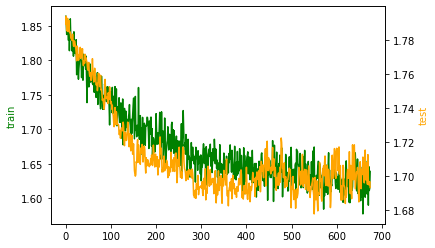

In [13]:
ax = plt.subplot((111))
plt.plot(train_loss[25:], 'green')
plt.ylabel('train', c='green')
ax2= ax.twinx()
plt.plot(test_loss[25:], 'orange')
plt.ylabel('test', c='orange')
plt.savefig(im_src+'loss_curves', dpi=200)

Train Data performance

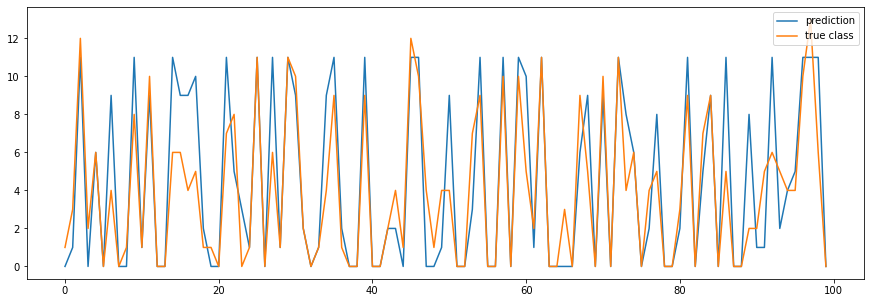

In [14]:
ann.eval() #set to evaluation mode
vx_train, pred_train = torch.max(torch.nn.functional.softmax(ann.forward(X_train).detach(),1) , 1)
vy_train, iy_train = torch.max(y_train, 1)
plt.figure(figsize=(15,5))
plt.plot(pred_train[0:100])
plt.plot(iy_train[0:100]);
plt.legend(['prediction', 'true class']);

Test data performance

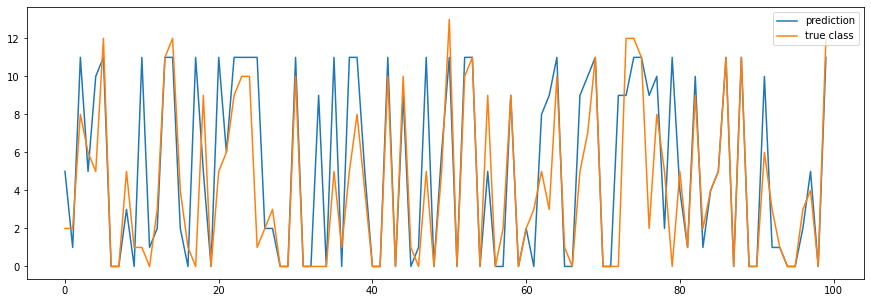

In [15]:
vx_test, pred_test = torch.max(torch.nn.functional.softmax(ann.forward(X_test).detach(),1), 1)
vy_test, iy_test = torch.max(y_test, 1)
plt.figure(figsize=(15,5))
plt.plot(pred_test[:100])
plt.plot(iy_test[:100]);
plt.legend(['prediction', 'true class']);

Print model accuracies and 95% confidence intervals

In [16]:
#this function takes in 2 lists of class predictions and returns the confidence 95% interval on the mean
def conf(list1,list2):
    a =np.array(list1==list2).astype(int)
    lower, upper =st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))
    return (upper-lower)/2

acc_train = accuracy_score(pred_train,iy_train)
acc_test = accuracy_score(pred_test,iy_test)

print("Training accuracy: {:.2f}±{:.2f}%".format( accuracy_score(pred_train,iy_train)*100,conf(pred_train, iy_train)*100) )
print("Testing accuracy: {:.2f}±{:.2f}%".format( accuracy_score(pred_test,iy_test)*100,conf(pred_test, iy_test)*100) )

Training accuracy: 40.15±1.94%
Testing accuracy: 39.68±6.14%


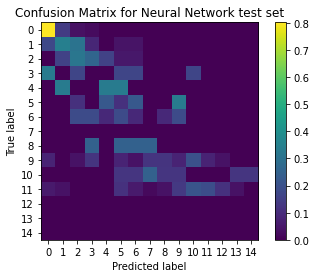

In [17]:
#confusion matrix over all classes
img = ConfusionMatrixDisplay.from_predictions(pred_test,iy_test,include_values=False, normalize='true');
plt.title("Confusion Matrix for Neural Network test set")
plt.savefig(im_src+'conf_matrix.png', dpi=200,facecolor='white' )

Plot Macro average over all classes ROC curve

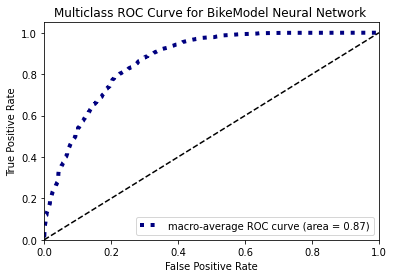

In [18]:
#Code adapted from scikit-learn:  https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
probas = torch.nn.functional.softmax(ann.forward(X_train).detach(),1)
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = {}

n_items = y_test.shape[1]
for i in range(n_items):
    fpr[i], tpr[i], _ = roc_curve(y_train[:, i], probas[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_items)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_items):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_items

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for BikeModel Neural Network ")
plt.legend(loc="lower right")
plt.savefig(im_src+'roc_auc_curve', dpi=200,facecolor='white' )
plt.show()

In [19]:
# np.save('results\\berri\\ann_out.npy',[pred_test.numpy(), iy_test.numpy()])
# np.save('results\\berri\\ann_fpr_tpr.npy',[fpr['macro'],tpr['macro'],roc_auc])

In [20]:
#np.save('results\\berri\\ann_trn_tst.npy',[acc_train,acc_test])
#np.save('results\\maison1\\ann_trn_tst.npy',[acc_train,acc_test])
np.save('results\\maison2\\ann_trn_tst.npy',[acc_train,acc_test])